# Eco-evolutionary dynamics in consumer-resource models
Zhijie Feng

Here we use constraint optimization mapping to simualte invasion in consumer-resource models. There are several model choises we can make. Here we allow two types of resource dynamics: MacArthur or linear. And we can choose wherther we allow resource to extinct (permanently), and whether new resource invade simultaneously with consumers.
## Models
MacArthur Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= R_{\alpha}( k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_j)
\end{align*}

Linear resource dynamics Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_jR_{\alpha}
\end{align*}

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
from scipy import stats
import time
import pickle
from collections import  defaultdict

In [2]:
cd /Users/zhijie/Documents/GitHub/eco-evolution-simulator

/Users/zhijie/Documents/GitHub/eco-evolution-simulator


In [3]:
from IPython.display import Image


## Invasion dynamics simulation
Here we construct the class TrajectorySimulator to simulate one invasion trajectory with given input parameters. For each step of the trajectory, a indaver is generated, and invade the ecologically stable ecosystem. Since successful invasion is possible only if invader's immediate growth rate is positive, we check it to reduce computation time. We update the ecosystem by computing the new steady state with the invader added.


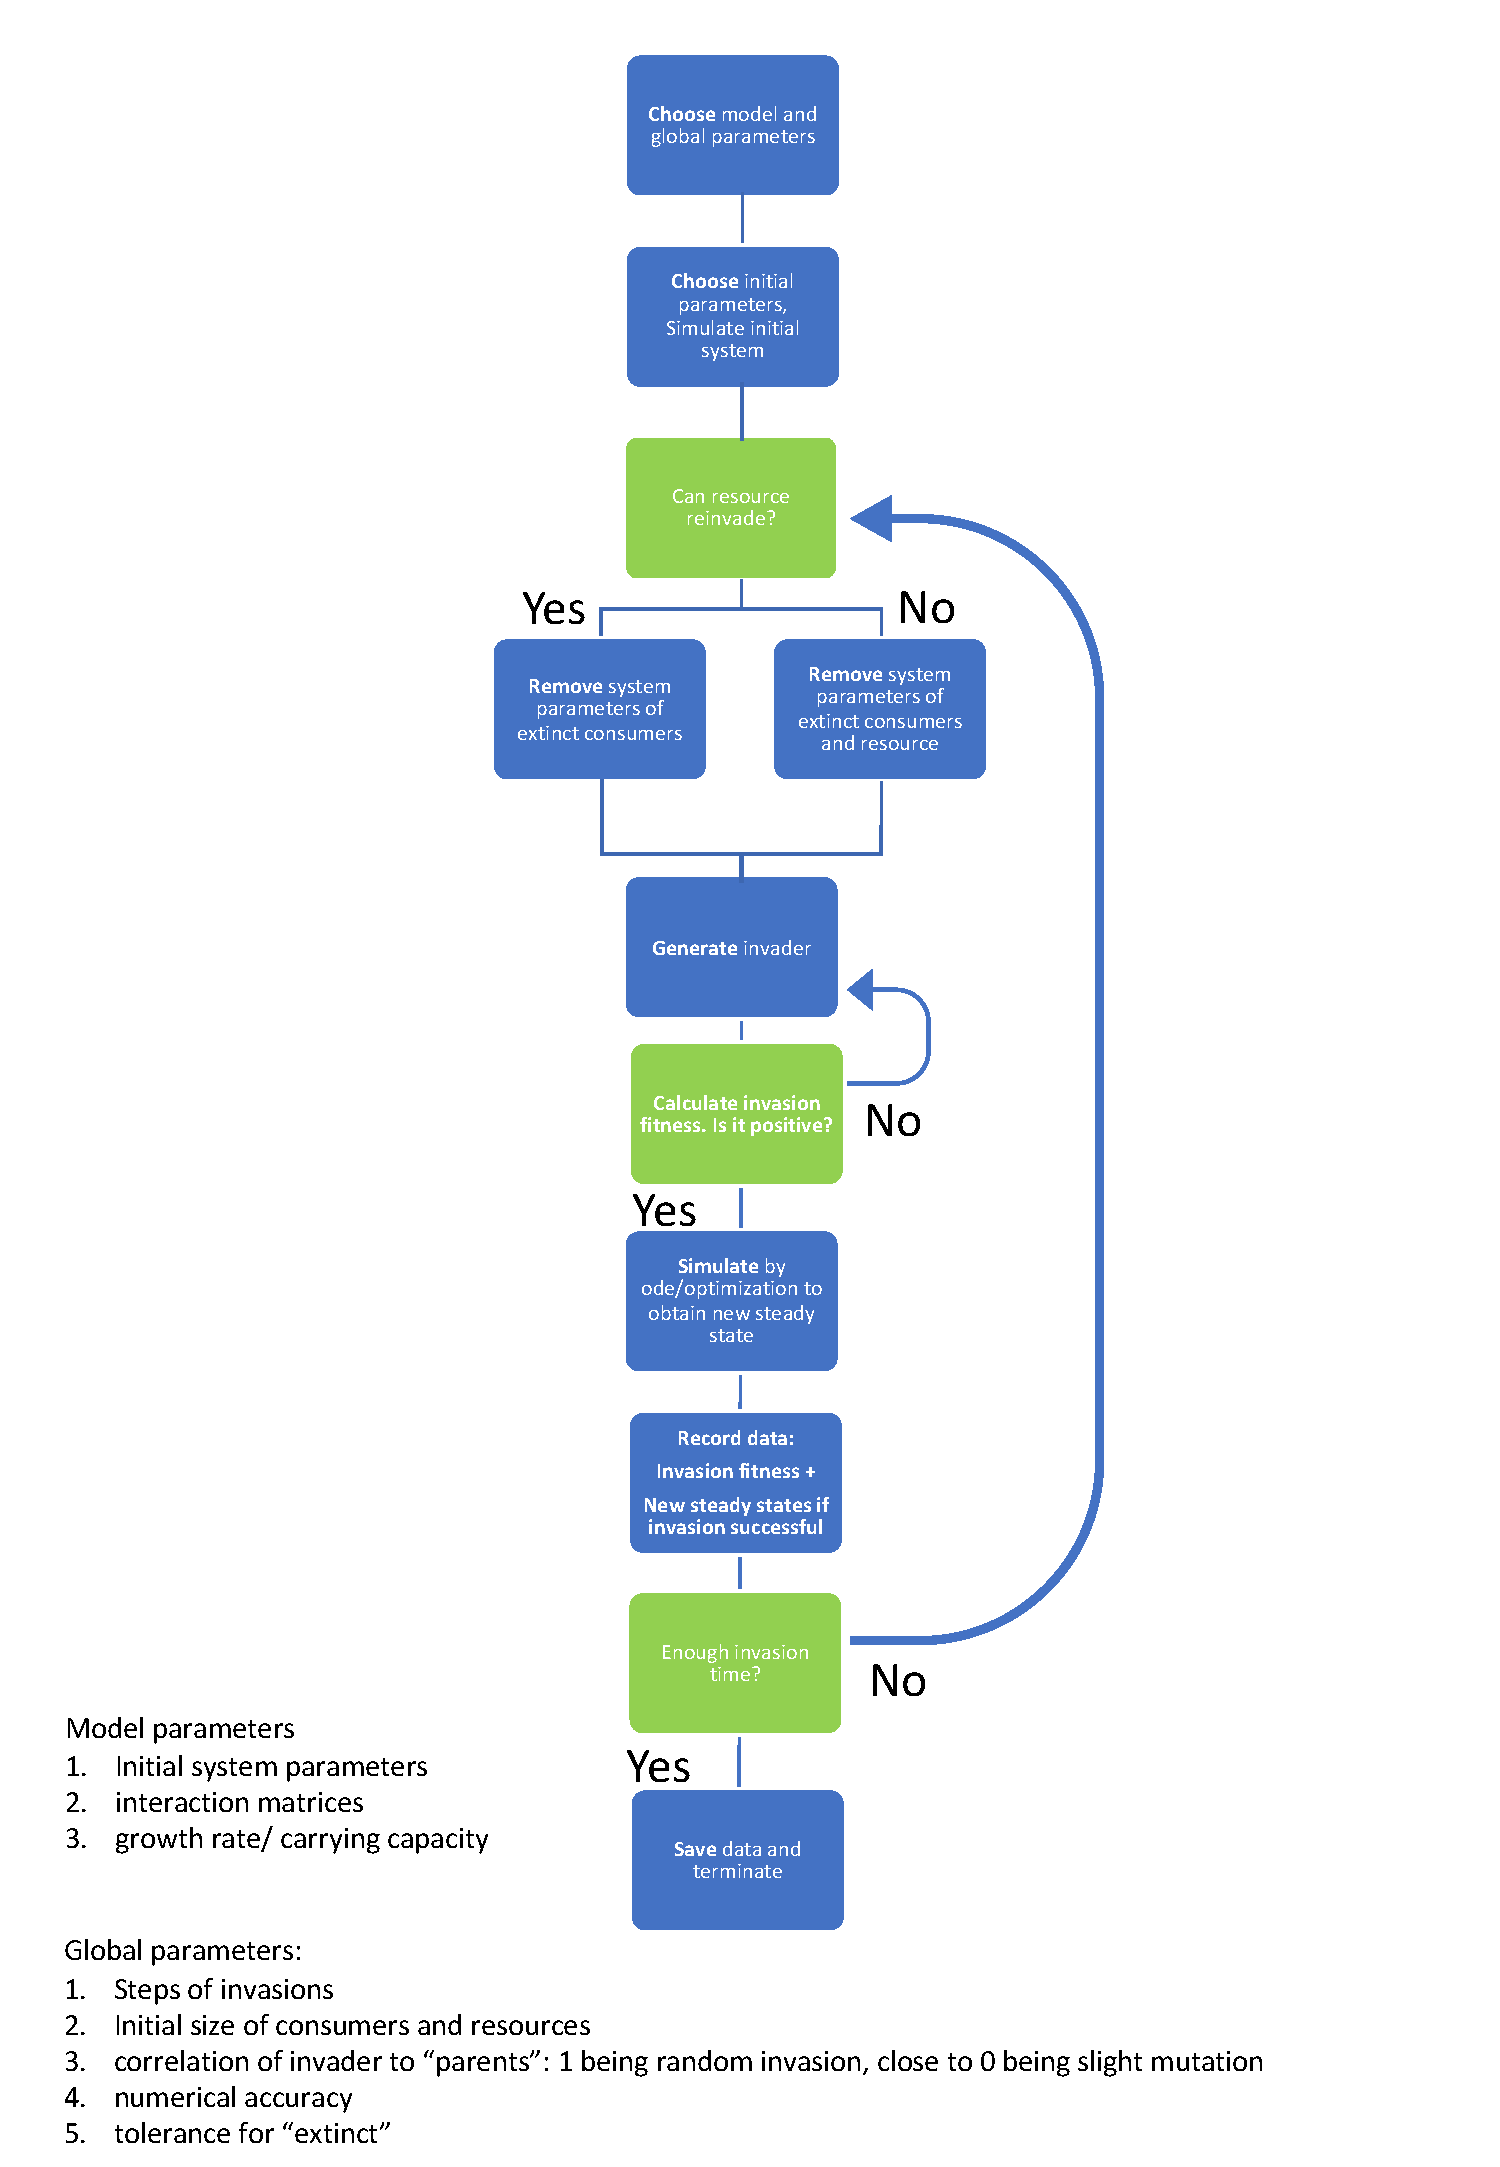

In [4]:
Image("flowchart.png")


In [458]:
class TrajectorySimulator:
    def __init__(self, input_params):
        # Initialize the simulation parameters
        self.top_species = input_params['top_species']
        self.resources = input_params['resources']
        self.mean_k = input_params['mean_k']
        #self.sigma_k = input_params['sigma_k']
        self.mean_m = input_params['mean_m']
        self.sigma_m = input_params['sigma_m']
        self.total_invasion = input_params['total_invasion']
        self.resource_dynamics = input_params['resource_dynamics']
        self.resource_extinct = input_params['resource_extinct']
        self.resource_invade = input_params['resource_invade']
        self.mutation_weight = input_params['mutation_weight']
        self.C_mean = input_params['mean_c']
        self.sigma_c = input_params['sigma_c']
        # Initialize data storage for simulation results by defaultdict, which automatically initialize dictionary elements with empty lists
        self.results=defaultdict(list) 
        # Save the input parameters in the result too
        self.results['input_params'] = input_params


    def initialize_parameters(self):
        # Initialize the consumer and resource matrices and vectors
        self.C = self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        self.m = np.ones(self.top_species) *self.mean_m
        self.k = np.ones(self.resources) * self.mean_k
        self.results['initial_C']=self.C
        self.results['initial_m']=self.m
        self.results['initial_k']=self.k
        
    def initialize_ecosystem(self):
        top_survived=[]
        while  sum(top_survived) <1: #start ecosystem with at least 1 surviving consumer
            self.initialize_parameters()
            N_opt_value, R_opt_value = self.steady_state()
            top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
        
        self.results['initial_N']=N_opt_value
        self.results['initial_R']=R_opt_value
        self.results['initial_N_survived']=top_survived
        self.results['initial_R_survived']=resources_survived
        self.extinction(top_survived, resources_survived) 
            
        return N_opt_value, R_opt_value, top_survived, resources_survived
         
    def record_results(self, invasion, N_opt_value, R_opt_value, top_survived, resources_survived, invasionC, invasionm,invasionR,invasionk,parent_index):
        # Record simulation results for the successful invasion
        self.results['successful_index'].append(invasion) # the invasion times that sucessful invasion happened
        self.results['List_packing'].append(sum(top_survived) / sum(resources_survived)) #the ratio of number of surviving consumers over number of surviving consumers
        self.results['List_meanfitness'].append(np.mean(self.C @ self.k - self.m))#the system average of CK-m
        self.results['List_N'].append(N_opt_value) #each data is a list of consumer abundance for each species that survive in the last step, plus final element being the invader  
        self.results['List_R'].append(R_opt_value) #each data is a list of resource abundance for each resources that survive in the last step, plus final element being the invader  
        self.results['List_surviveN'].append(top_survived) #each data is a list of boolean variable, being 1 means the consumer is recognized as survived
        self.results['List_surviveR'].append(resources_survived) #each data is a list of boolean variable, being 1 means the resource is recognized as survived
        self.results['List_invasionC'].append(invasionC) #invader's consumer perference
        self.results['List_invasionm'].append(invasionm) #invader's death rate
        if self.resource_invade:
            self.results['List_invasionR'].append(invasionR) #invader resource's consumer perference
            self.results['List_invasionk'].append(invasionk) #invader resource's carrying capacity
        #self.results['testC'].append(self.C) # for testing the reconstruct function in SimulationAnalyzer
        self.results['parent_indices'].append(parent_index)
        
    def all_invasion_record_results(self,invasion_fitness):
        # Record the result for both any invasions
        self.results['List_invasion_fitness'].append(invasion_fitness) #invasion fitness defined as the immediate growth rate of invader when the it is introduced
            
    def invade(self, R_opt_value, resources_survived, invasionC, invasionm, invasionR, invasionk):
        # Add invading species into the model
        self.C, self.m = np.concatenate((self.C, invasionC)), np.concatenate((self.m, invasionm))
        if self.resource_invade:
            self.C, self.k = np.concatenate((self.C, invasionR), axis=1), np.concatenate((self.k, invasionk))

    def extinction(self, top_survived, resources_survived):
        # Handle species extinction in the model
        if self.resource_extinct:
            self.C, self.m, self.k = self.C[top_survived, :][:, resources_survived], self.m[top_survived], self.k[resources_survived]
        else:
            self.C, self.m = self.C[top_survived, :], self.m[top_survived]
            
    def steady_state(self):
        # Calculate the steady-state of the model
        R_opt = cvx.Variable(len(self.k))
        if self.resource_dynamics == 'MCRM':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - self.k)), constraints)
            prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True, verbose=False)
        elif self.resource_dynamics == 'linear':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(self.k + 1e-9, R_opt + 1e-9))), constraints)
            prob_output = prob.solve(solver=cvx.ECOS, abstol=1e-7, reltol=1e-7, warm_start=True, verbose=False, max_iters=100000)
        return  prob.constraints[0].dual_value, R_opt.value

    def mutation(self, parent, mutate):
        # Apply mutation to a species
        return self.mutation_weight * mutate + (1 - self.mutation_weight) * parent
    
    def get_invasion_fitness(self, invasionC, invasionm, R_opt_value, resources_survived):
        invasion_fitness = invasionC @ R_opt_value[resources_survived] - invasionm if self.resource_extinct else invasionC @ R_opt_value - invasionm
        if len(invasion_fitness)>1:print("invasion fitness error")
        return invasion_fitness[0]
    
    def generate_uncorrelated_invader(self,top_survived,resources_survived):
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[-1] #usually the dimension of C tells the niche dimension, unless no consumer survive
        elif self.resource_extinct: niches_dim = sum(resources_survived)
        else: niches_dim = len(resources_survived)
        
        invasionC =  self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (1, niches_dim)) / np.sqrt(self.resources)
        invasionm = self.sigma_m*np.random.normal(0, 1, (1))+self.mean_m
        return invasionC, invasionm
    
    def generate_uncorrelated_new_resource(self,top_survived,resources_survived):
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[0]+1 #usually the dimension of C tells the niche dimension, unless no consumer survive
        else: niches_dim = len(top_survived)+1
        # the +1 comes from the fact that consumers invade
        
        invasionR = self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (niches_dim, 1)) / np.sqrt(self.resources)
        invasionk = self.sigma_m*np.random.normal(0, 1, (1))+self.mean_k
        return invasionR, invasionk
    
       
    def determine_survival(self,N_opt_value,R_opt_value,N_threshold=1e-5, R_threshold=1e-5):
        return N_opt_value > N_threshold, R_opt_value > R_threshold
    
    def run_simulation(self):
        N_opt_value, R_opt_value,top_survived, resources_survived=self.initialize_ecosystem()
        old_N_opt_value = N_opt_value
        List_invasion_fitness = []
        
        for invasion in range(self.total_invasion):
            invasionC, invasionm = self.generate_uncorrelated_invader(top_survived,resources_survived)
            if self.resource_invade: 
                invasionR, invasionk = self.generate_uncorrelated_new_resource(top_survived,resources_survived)
            else: invasionR, invasionk = None, None
                
            parent_index = np.random.randint(len(self.C))
            invasionC, invasionm = self.mutation(np.array([self.C[parent_index]]), invasionC), self.mutation(np.array([self.m[parent_index]]), invasionm)

            invasion_fitness = self.get_invasion_fitness(invasionC, invasionm, R_opt_value, resources_survived)
            self.all_invasion_record_results(invasion_fitness)
            if self.resource_invade: invadebool=1
            else:
                invadebool = invasion_fitness > 0 #invasion only possible when immediate growth rate is positive
            
            if invadebool:     
                self.invade(R_opt_value, resources_survived, invasionC, invasionm, invasionR, invasionk)
                N_opt_value, R_opt_value = self.steady_state() 
                top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
                self.extinction(top_survived, resources_survived) 
                    
                if not np.array_equal(N_opt_value, old_N_opt_value): # Only record when invasion is successful
                    old_N_opt_value = N_opt_value
                    self.record_results(invasion, N_opt_value, R_opt_value, top_survived, resources_survived,invasionC, invasionm, invasionR, invasionk, parent_index)
                    
        return self.results

#Here is an easy example to check if the simulation is working
if __name__ == '__main__':
    input_params = {
        'top_species': 1, # initial number of species of consumers
        'resources': 30, # initial number of species of resources
        'mean_k': 15, #mean value of k
        #'sigma_k': 0.1, #standard deviation of k
        'mean_m': 1, #mean value of m
        'sigma_m': 0.1, #standard deviation of k
        'total_invasion': 10000, #total number of invasion steps
        'resource_dynamics': 'MCRM', #type of resource dynamics in the model, it can be 'MCRR' or 'linear'
        'resource_extinct': False, # whether we remove resource permenantly if it extinct in one invasion step
        'resource_invade': False, # whether we simultaneously let a random resource invade
        'mutation_weight': 0.01, # 1 - correlation of invader to “parents”: 1 being random invasion, ->0 being slight mutation
        'mean_c' : 1,#mean value of element of C
        'sigma_c' : 1, #standard deviation of element of C
    }
    
    start_time = time.time()
    
    simulator = TrajectorySimulator(input_params)
    oneresult = simulator.run_simulation()
    
    print("--- %s seconds ---" % (time.time() - start_time))


--- 13.656611204147339 seconds ---


# Simulation iteration
We construct functions to iterate any number of parameters each over specified ranges, with parrallel computing. And we save the result with pickle.

In [554]:
from itertools import product
from joblib import Parallel, delayed

def run_simulation_repeat(input_params, repeat):
    # Add the repeat information to input_params
    simulator = TrajectorySimulator(input_params)
    input_params['repeat'] = repeat
    result = simulator.run_simulation()

    return result

def iterate_over_parameter_ranges(parameter_ranges, common_input_params, repeats=1):
    results_dict = {}

    # Create a list of dictionaries representing all combinations of parameter values
    param_combinations = list(product(*(param_range['values'] for param_range in parameter_ranges)))

    # Use joblib to parallelize the execution of simulations
    results = Parallel(n_jobs=-1)(delayed(run_simulation_repeat)(input_params, repeat) for repeat in range(repeats) for input_params in
                                  [{**common_input_params, **{param_range['param_name']: value for param_range, value in zip(parameter_ranges, param_values)}}
                                   for param_values in param_combinations])

    #Iterate over all parameter combinations and store the results
    for i, (param_values, repeat) in enumerate(product(param_combinations, range(repeats))):
        input_params = {
            **common_input_params,
            **{param_range['param_name']: value for param_range, value in zip(parameter_ranges, param_values)},
            'repeat': repeat + 1
        }
        result = results[i]

       #  Create a key that combines parameter values and repeat information
        param_key = "_".join([f"{param_range['param_name']}={value}" for param_range, value in zip(parameter_ranges, param_values)])
        param_key += f"_repeat={repeat + 1}"
        results_dict[param_key] = result
              
    # Save the results to a file using pickle
    with open(filename, 'wb') as file:
        pickle.dump(results_dict, file)

start_time = time.time()
filename = 'simulation_results.pkl'

if __name__ == '__main__':
    # Define parameter ranges 
    parameter_ranges = [
        {
            'param_name': 'mutation_weight',
            'values': [0.01, 0.1, 0.9]
        },
        {
            'param_name': 'mean_m',
            'values': [1, 2]
        },
        # Add more parameter ranges as needed
        # ...
    ]

    # Common input parameters
    common_input_params = {
        'top_species': 3,
        'resources': 30,
        'total_invasion': 10000,
        'resource_dynamics': 'MCRM',
        'resource_extinct': False,
        'resource_invade': False,
        'mean_m': 1,
        'sigma_m': 0.1,
        'sigma_k': 0.1,
        'sigma_c': 1,
        'mean_k' : 10,
        'mean_c' : 1
        
    }

    # Call the function to iterate over parameter ranges and run simulations
    iterate_over_parameter_ranges(parameter_ranges, common_input_params, 20)
print("--- %s seconds ---" % (time.time() - start_time))


--- 96.51573991775513 seconds ---


## Simulation Analyzer
We use SimulationAnalyzer class to process the data to reconstruct the full dynamics, and obtain meaningful output for plotting.

In [555]:
class SimulationAnalyzer:
    
    def __init__(self, results):
        self.results = results     

    def get_parent_coexistence_bool_list(self):
        parent_coexistence_bool_list=[]
        N_survive=self.results['List_surviveN']
        parent_indices=self.results['parent_indices']
        for i in range(len(parent_indices)):
            parent_index=parent_indices[i]
            if N_survive[i][parent_index]== True : parent_coexistence_bool_list.append(1)
            else: parent_coexistence_bool_list.append(0)
        return parent_coexistence_bool_list
        
    def get_mean_variance_total_N(self):
        N_values = self.results['List_N']
        mean_N = [np.mean(N) for N in N_values]
        variance_N = [np.var(N) for N in N_values]
        total_N=[np.sum(N) for N in N_values]
        return np.array(mean_N), np.array(variance_N), np.array(total_N)
    
    def get_mean_variance_total_R(self):
        R_values = self.results['List_R']
        mean_R = [np.mean(R) for R in R_values]
        variance_R = [np.var(R) for R in R_values]
        total_R=[np.sum(R) for R in R_values]
        return np.array(mean_R), np.array(variance_R), np.array(total_R)
    
    def get_N_R_num_survived(self):
        N_survive, R_survive=self.results['List_surviveN'],self.results['List_surviveR']
        num_N_survived=[np.sum(survivalbool) for survivalbool in N_survive]
        num_R_survived=[np.sum(survivalbool) for survivalbool in R_survive]
        return np.array(num_N_survived), np.array(num_R_survived), np.array(total_R)
    
    def get_diff_N_R(self):
        N_values, R_values = self.results['List_N'], self.results['List_R']
        Ndiff, Rdiff = [], []
        
        this_N=self.results['initial_N']
        this_R=self.results['initial_R']
        top_survived = self.results['initial_N_survived']
        resources_survived = self.results['initial_R_survived']
        #to get delta N and R, first remove all extinct species, and add a 0 at the last, finally subtract with with the next vector
        
        for i in range(len(self.results['List_invasionC'])):
            #format N so deltaN can be calculated
            this_N = this_N [top_survived]
            this_N = np.concatenate((this_N,np.array([0])))
            
            next_N = N_values[i]
            Ndiff.append(np.array(next_N)-np.array(this_N))
            
            
            if self.results['input_params']['resource_extinct'] : this_R = this_R [resources_survived]
            if self.results['input_params']['resource_invade'] : this_R=np.concatenate((this_R,np.array([0])))
            next_R = R_values[i]
            Rdiff.append(np.array(next_R)-np.array(this_R))
            
            this_N = next_N
            this_R = next_R
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
           
                        
        return Ndiff, Rdiff
    

    
    def reconstruct_extinction(self, top_survived, resources_survived, C, m, k):
        if self.results['input_params']['resource_extinct']:
            new_C, new_m, new_k = C[top_survived, :][:, resources_survived],m[top_survived], k[resources_survived]
        else:
            new_C, new_m, new_k = C[top_survived, :], m[top_survived], k
        return  new_C, new_m, new_k
    
    def reconstruct_invade(self, invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) :
        new_C, new_m, new_k = np.concatenate((C, invasion_C)), np.concatenate((m, invasion_m)), k
        resources=self.results['input_params']['resources']
        if self.results['input_params']['resource_invade']:
            new_C, new_k = np.concatenate((new_C, invasion_R), axis=1), np.concatenate((new_k, invasion_k))
        return new_C, new_m, new_k
    
    
    
    def reconstruct_C_m_k(self):
        C = self.results['initial_C'].copy()
        m = self.results['initial_m'].copy()
        k = self.results['initial_k'].copy()
        top_survived = self.results['initial_N_survived']
        resources_survived = self.results['initial_R_survived']
        
        C, m, k = self.reconstruct_extinction(top_survived, resources_survived, C, m, k)
        
        reconstructed_C = []
        reconstructed_m = []
        reconstructed_k = []

        for i in range(len(self.results['List_invasionC'])):
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
            
            invasion_C = self.results['List_invasionC'][i]
            invasion_m = self.results['List_invasionm'][i]
            

            if self.results['input_params']['resource_invade']:
                invasion_R = self.results['List_invasionR'][i]
                invasion_k = self.results['List_invasionk'][i]
                
            else: invasion_R, invasion_k = None, None
             # Update the current state with the invasion data
            C, m, k = self.reconstruct_invade(invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) 
           
            # Update the current state with the extinction data
            C, m, k = self.reconstruct_extinction(top_survived, resources_survived, C, m, k)
            
            
            # Append the current state to the lists
            reconstructed_C.append(np.array(C.copy()))
            reconstructed_m.append(np.array(m.copy()))
            reconstructed_k.append(np.array(k.copy()))

        return reconstructed_C, reconstructed_m, reconstructed_k

# Demonstrate assuming you have oneresult as the simulation results
analyzer = SimulationAnalyzer(oneresult)
#testing reconstruction function
#listC, listm, listk=analyzer.reconstruct_C_m_k()
#for i in range(len(listC)):
#    if not np.allclose(listC[i],oneresult['testC'][i]): print('reconstruction error')

# Visualization
Here we visualize the result we collected from the simulations

In [556]:
def load_results(filename):
    with open(filename, 'rb') as file:
        results_dict = pickle.load(file)
    return results_dict

def plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale='linear', yscale='linear', ax=None, legend=False, kwargs=False):
    if ax is None:
        ax = plt.gca()
        plt.figure()
        legend=True

    for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        #x_data and y_data can be either keys from the result_dict or functions that operate on a SimulationAnalyzer
        x_values = x_data(analyzer) if callable(x_data) else result[x_data]
        y_values = y_data(analyzer) if callable(y_data) else result[y_data]
        if kwargs: ax.plot(x_values, y_values, label=param_key, alpha=0.5, **kwargs)
        else: ax.plot(x_values, y_values, label=param_key, alpha=0.5)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
        
    if legend:
        ax.legend(bbox_to_anchor=(1, 1))
        
def iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='linear', yscale='linear', kwargs=False):
    num_plots = len(x_data_list)
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots+3, 3))

    for i in range(num_plots):
        x_data = x_data_list[i]
        y_data = y_data_list[i]
        x_label = x_label_list[i]
        y_label = y_label_list[i]

        plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale, yscale, ax=axs[i], kwargs=kwargs)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

        

    
def plot_histogram_results(results_dict, data, x_label, y_label, kwargs=False):
    for param_key, result in results_dict.items():
        #values = result[data]
        analyzer = SimulationAnalyzer(result)
        values= data(analyzer) if callable(data) else result[data]
        if kwargs: plt.hist(values, **kwargs,label=param_key,)
        else: plt.hist(values, label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()    


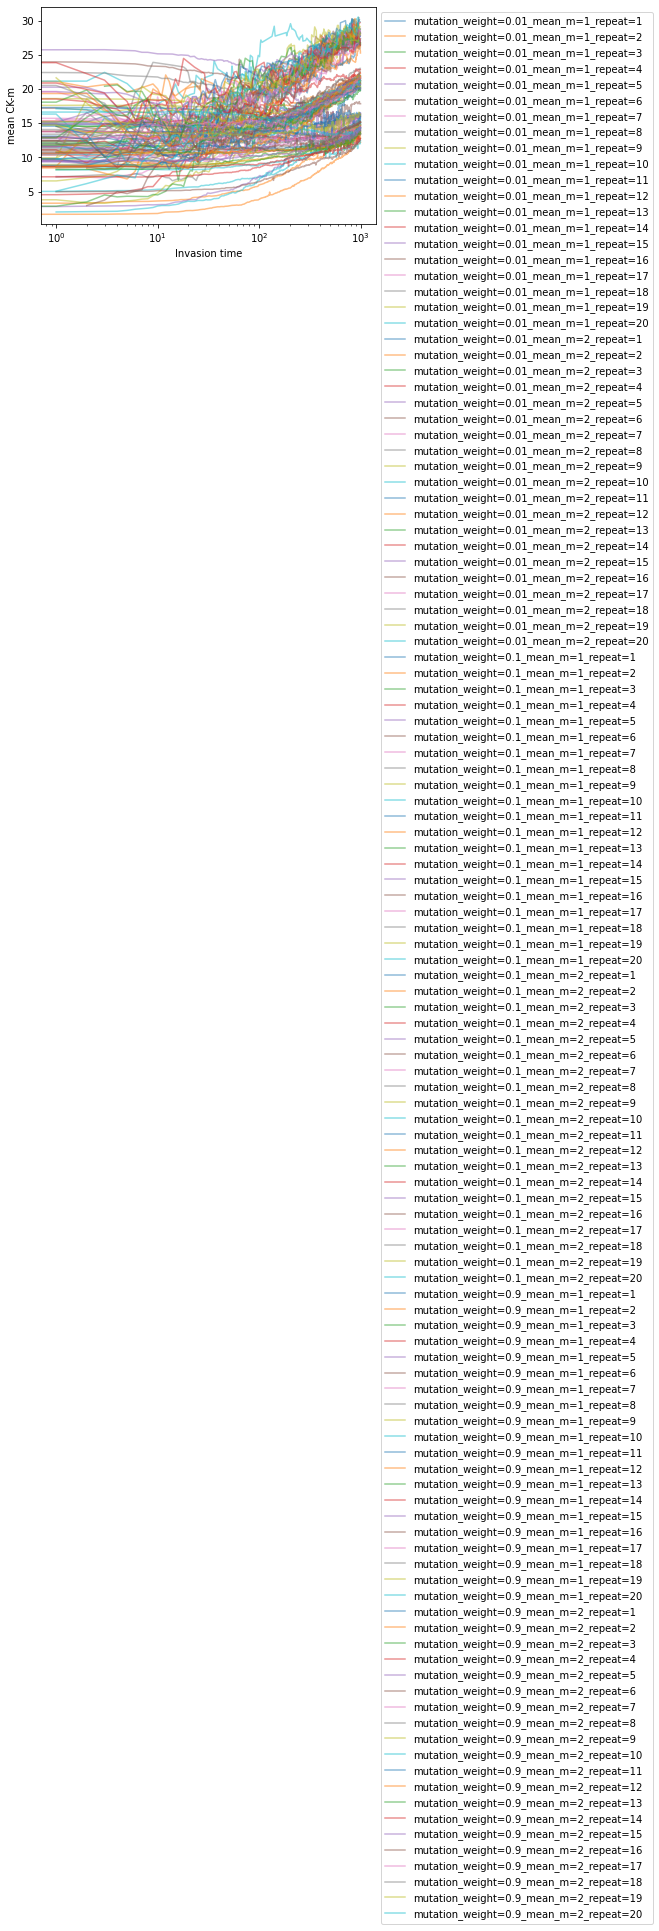

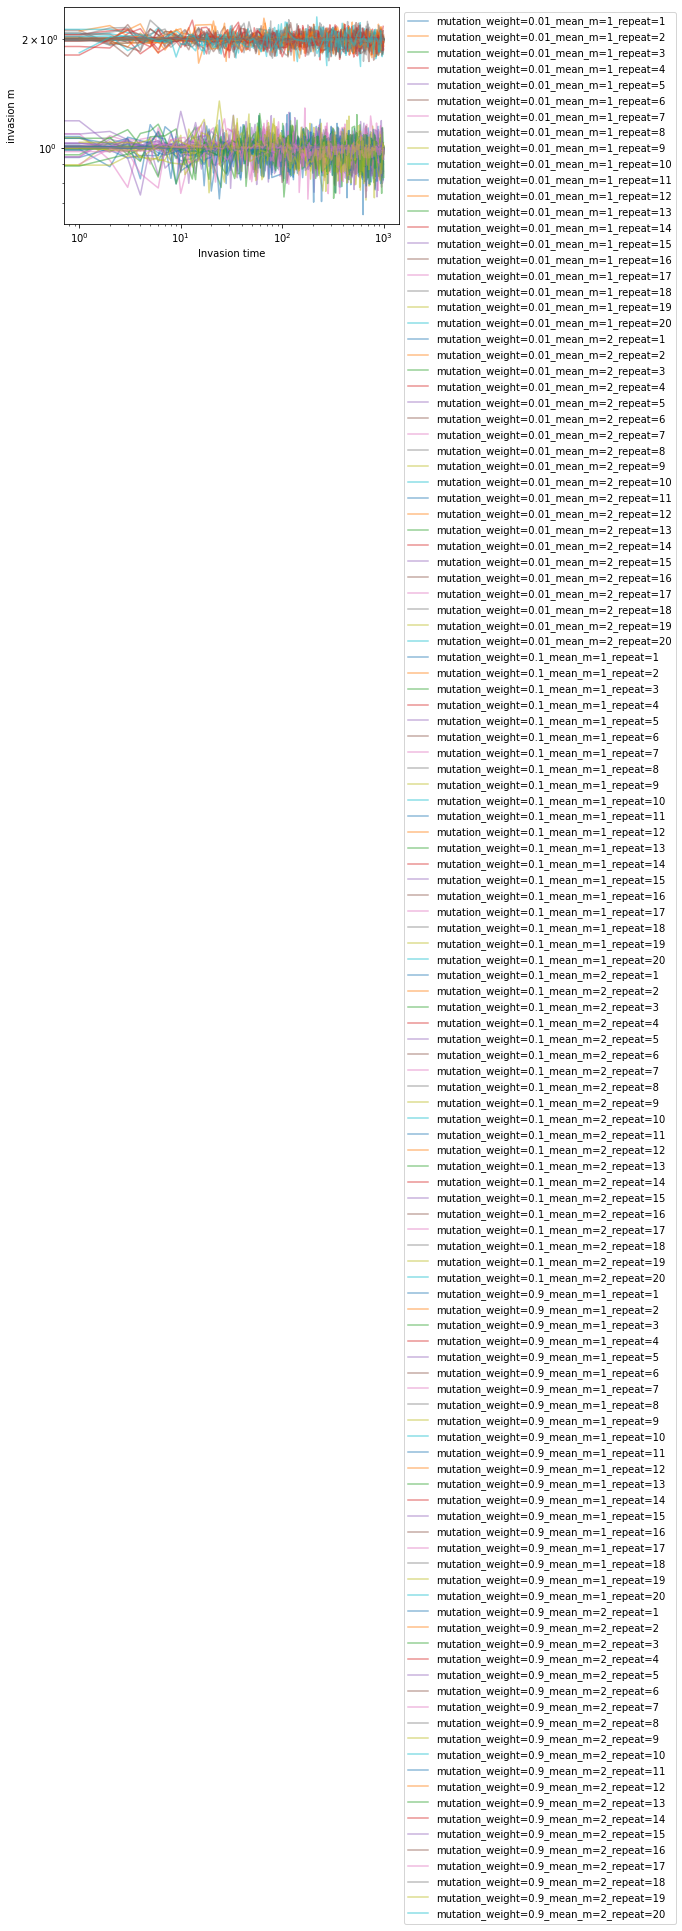

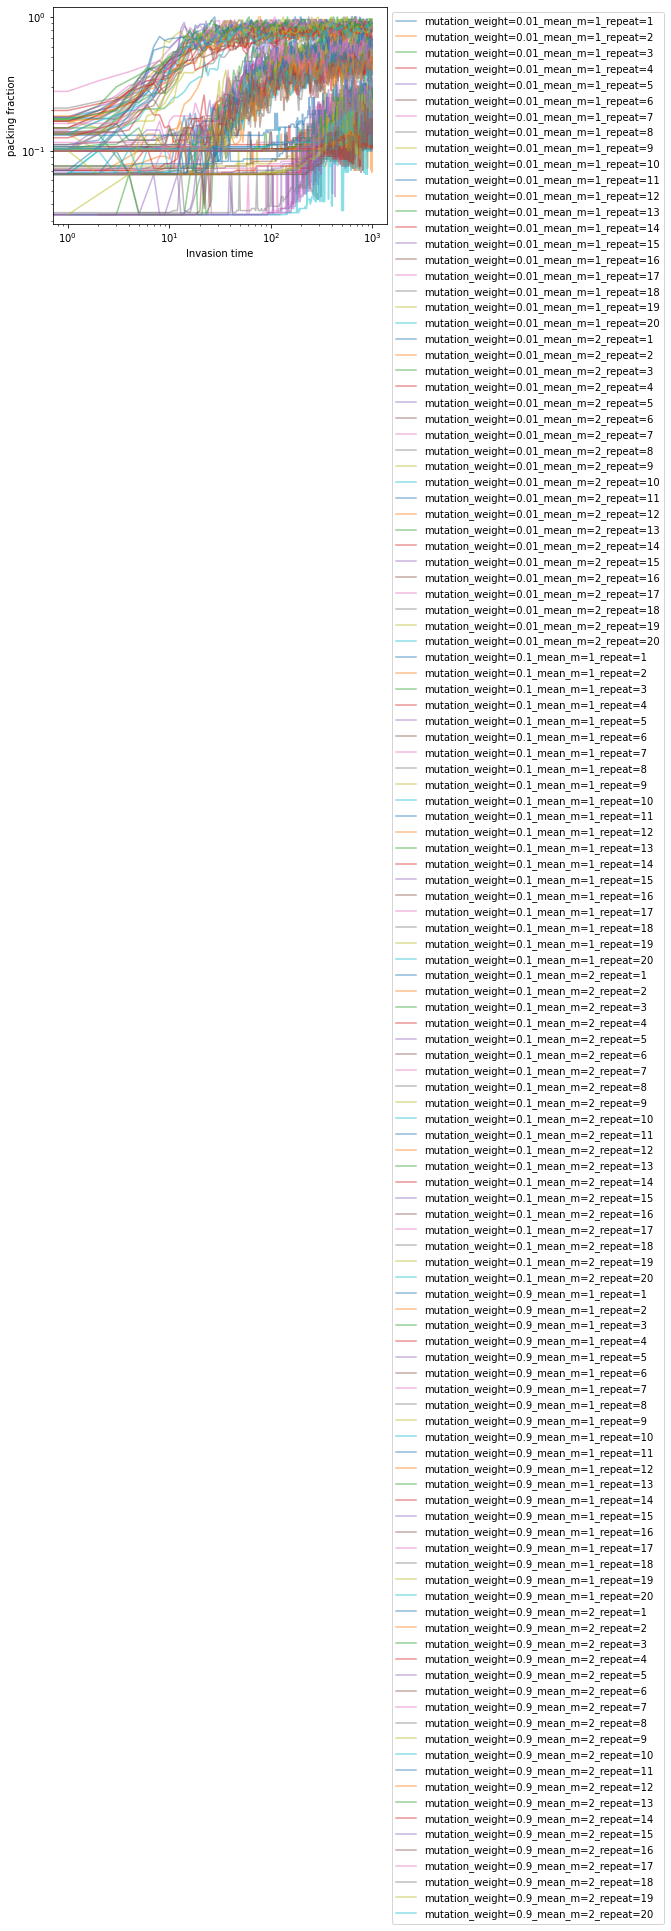

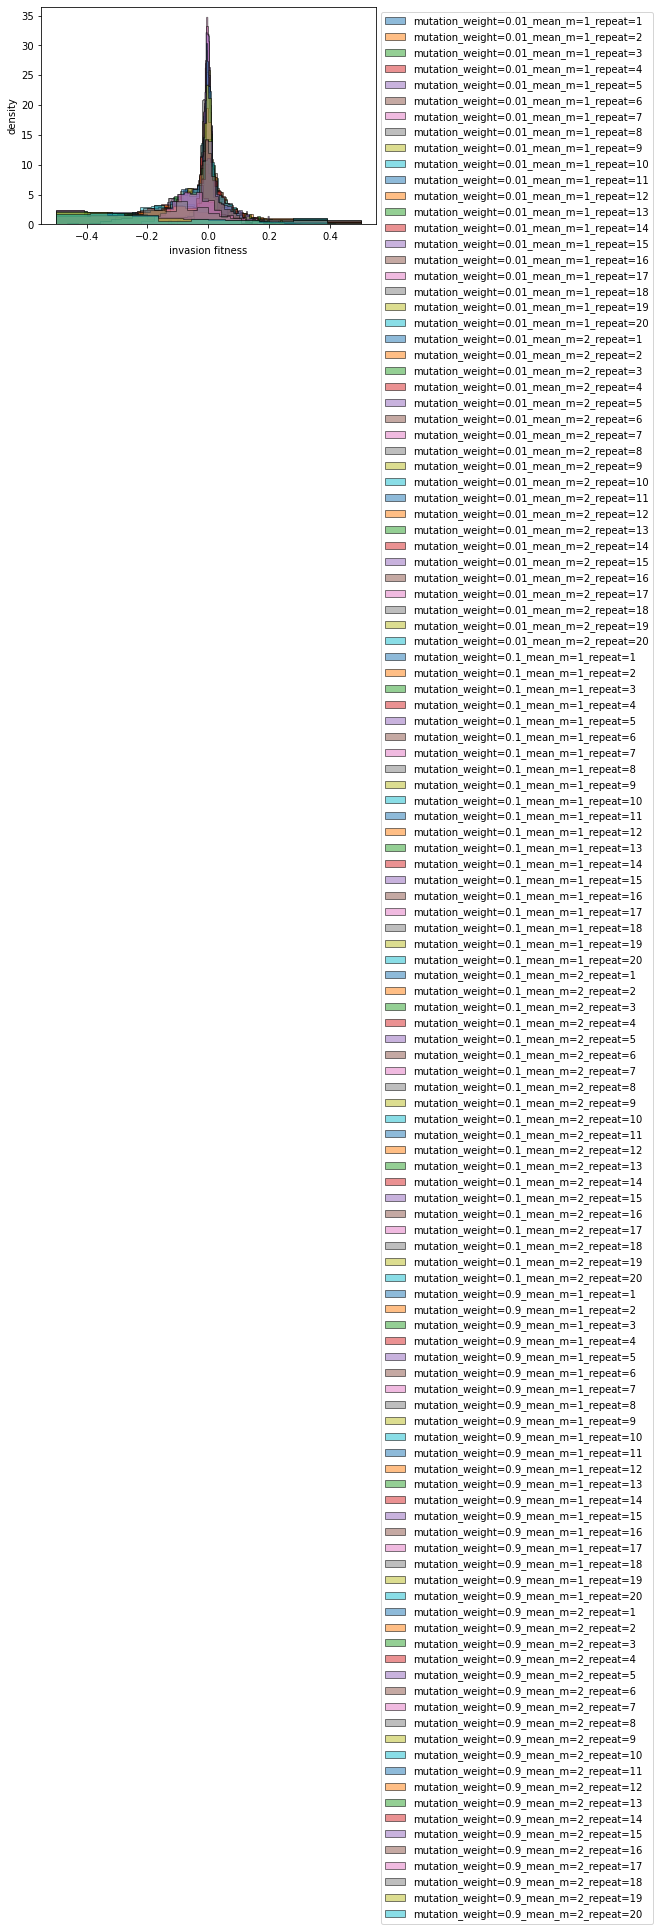

In [557]:
if __name__ == '__main__':
    # Load the saved results    
    results_dict = load_results(filename)

    plot_2d_results(results_dict, 'successful_index','List_meanfitness','Invasion time','mean CK-m',xscale='log')
    
    plot_2d_results(results_dict, 'successful_index','List_invasionm','Invasion time','invasion m',xscale='log',yscale='log')

    plot_2d_results(results_dict, 'successful_index','List_packing','Invasion time','packing fraction',xscale='log',yscale='log')    
    kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins='auto', ec="k",range=[-0.5,0.5])
    plot_histogram_results(results_dict,"List_invasion_fitness", "invasion fitness","density", kwargs)

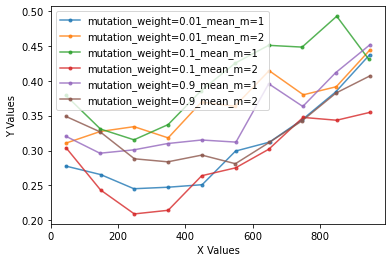

In [562]:
def restructure_results(results_dict): #restructure to easily analyze the repeats
    grouped_results = {}

    for param_key, result in results_dict.items():
        # Remove the repeat information from the param_key
        param_key_base = '_'.join(param_key.split('_')[:-1])

        # If the base param_key is not in the grouped_results, create a new entry
        if param_key_base not in grouped_results:
            grouped_results[param_key_base] = []

        # Append the result to the list under the corresponding base param_key
        grouped_results[param_key_base].append(result)
    return grouped_results


#for param_key, result in grouped_results.items():
#    print (param_key)

def flatten_nested_list(nested_list):
    return np.array([item for sublist in nested_list for item in sublist])

def plot_binned_scatter(x_values, y_values, num_bins,label):
    # Use numpy's histogram function to get bin indices for each x-value
    bin_indices = np.digitize(x_values, bins=np.linspace(min(x_values), max(x_values), num_bins + 1))

    # Calculate the mean y-values for each bin
    bin_means = [np.mean(y_values[bin_indices == i]) for i in range(1, num_bins + 1)]

    # Calculate the mean x-values for each bin
    bin_centers = [np.mean(x_values[bin_indices == i]) for i in range(1, num_bins + 1)]

    # Plot the binned scatter plot
    #plt.scatter(x_values, y_values, label='Original Data', alpha=0.5)
    plt.plot(bin_centers, bin_means, label=label, marker='.', alpha=0.8)

    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    #plt.legend()
    #plt.show()

grouped_results=restructure_results(results_dict)

for param_key, resultlist in grouped_results.items():
    coexistence_bools=[]
    invasion_times=[]
    
    for result in resultlist:
        analyzer = SimulationAnalyzer(result)
        coexistence_bools.append(analyzer.get_parent_coexistence_bool_list())
        invasion_times.append(result['successful_index'])
    
    y_values=flatten_nested_list(coexistence_bools)
    x_values=flatten_nested_list(invasion_times)

    plot_binned_scatter(x_values, y_values, num_bins=10,label=param_key)
plt.legend()
    # Example usage
#x_values = np.random.rand(100)
#y_values = x_values + np.random.normal(0, 0.1, 100)
#plot_binned_scatter(x_values, y_values, num_bins=10)

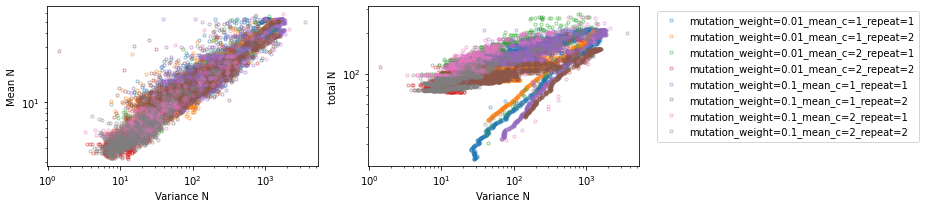

In [449]:
kwargs=dict(marker='o', markerfacecolor='None', markersize=3,linestyle='None')    

x_data_list = [lambda a: a.get_mean_variance_total_N()[1], lambda a: a.get_mean_variance_total_N()[1]]
y_data_list = [lambda a: a.get_mean_variance_total_N()[0], lambda a: a.get_mean_variance_total_N()[2]]
x_label_list = ['Variance N', 'Variance N']
y_label_list = [ 'Mean N','total N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log',kwargs=kwargs)

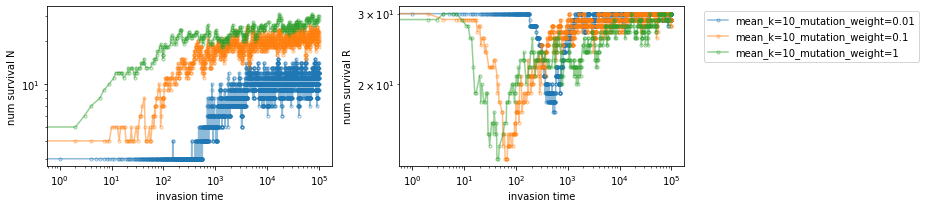

In [377]:
def get_num_N(analyzer):
    result=[]
    listN=analyzer.results['List_N']
    for item in listN:
        result.append(len(item))
    return result

def get_num_R(analyzer):
    result=[]
    list_survival_R=analyzer.results['List_surviveR']
    for item in list_survival_R:
        result.append(sum(item))
    return result
kwargs=dict(marker='o', markerfacecolor='None', markersize=3)    

x_data_list = ['successful_index','successful_index']
y_data_list = [get_num_N, get_num_R]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'num survival N','num survival R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list,xscale='log', yscale='log', kwargs=kwargs)

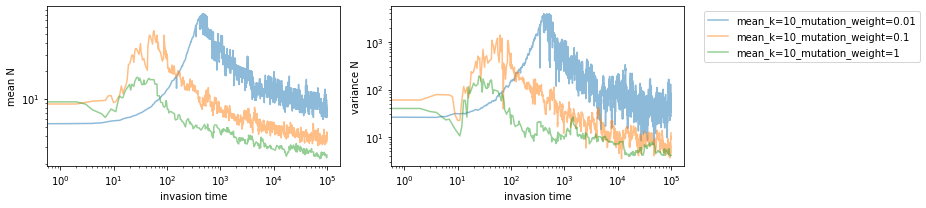

In [378]:

x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: a.get_mean_variance_total_N()[0], lambda a: a.get_mean_variance_total_N()[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean N','variance N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log')

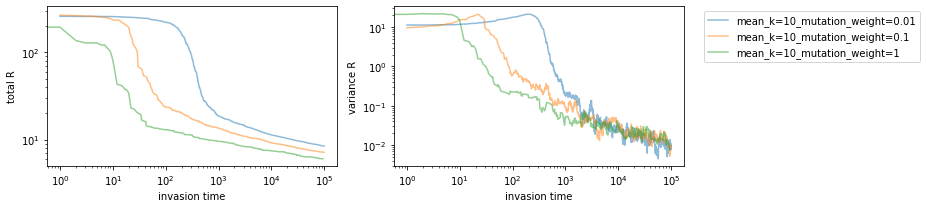

In [363]:

x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: a.get_mean_variance_total_R()[2], lambda a: a.get_mean_variance_total_R()[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'total R','variance R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log')

In [364]:
def mean_variance_nested_list(nested_list):
    list_mean=[]
    list_var=[]
    for List in nested_list:
        list_mean.append(np.mean(List))
        list_var.append(np.var(List))
    return list_mean,list_var

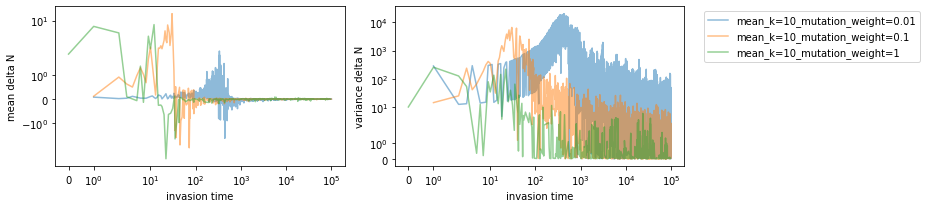

In [365]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(a.get_diff_N_R()[0])[0], lambda a: mean_variance_nested_list(a.get_diff_N_R()[0])[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean delta N','variance delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='symlog', yscale='symlog')

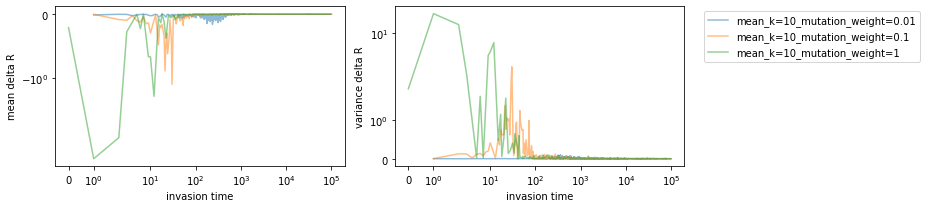

In [366]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(a.get_diff_N_R()[1])[0], lambda a: mean_variance_nested_list(a.get_diff_N_R()[1])[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean delta R','variance delta R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='symlog', yscale='symlog')

In [367]:
#take or remove internal elements of nested lists of unequal length
def take_invader(Nested_List):
    invader=[]
    for List in Nested_List:
        invader.append(List[-1])
    return invader

def remove_invader(Nested_List):
    noninvader=[]
    for List in Nested_List:
        noninvader.append(List[:-1])
    return noninvader    

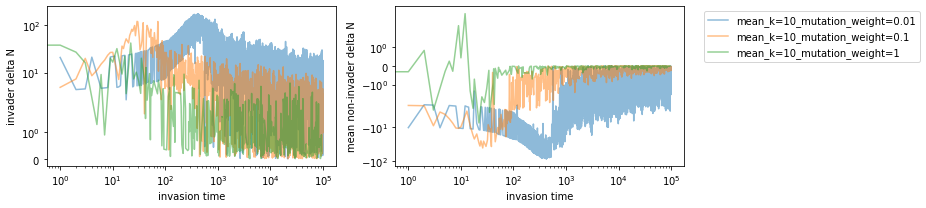

In [368]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(take_invader(a.get_diff_N_R()[0]))[0], lambda a: mean_variance_nested_list(remove_invader(a.get_diff_N_R()[0]))[0]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'invader delta N','mean non-invader delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='symlog')

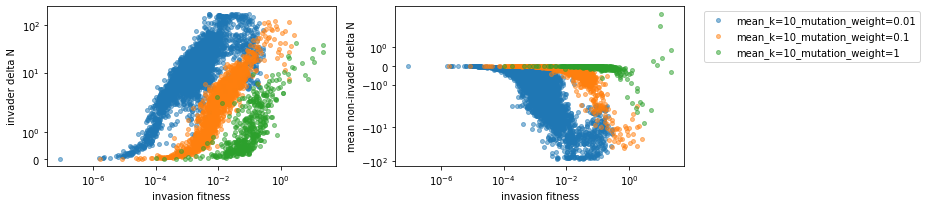

In [370]:
def get_sucessful_invasion_fitness(analyzer):
    all_fitness=analyzer.results['List_invasion_fitness']
    index=analyzer.results['successful_index']
    return np.take(all_fitness,index)

kwargs=dict(marker='o', markersize=4,linestyle='None')    
x_data_list = [get_sucessful_invasion_fitness,get_sucessful_invasion_fitness]
y_data_list = [lambda a: mean_variance_nested_list(take_invader(a.get_diff_N_R()[0]))[0], lambda a: mean_variance_nested_list(remove_invader(a.get_diff_N_R()[0]))[0]]
x_label_list = ['invasion fitness', 'invasion fitness']
y_label_list = [ 'invader delta N','mean non-invader delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='symlog',kwargs=kwargs)



In [ ]:
for param_key, result in results_dict.items():
    print(param_key)

result is [array([-3.21877941e-15, -2.37303432e-01]), array([ 4.55711857e-15, -1.02394288e-01]), array([-5.47999146e-15, -1.92152187e-03]), array([ 2.60468730e-15, -1.68661839e-01]), array([ 2.52835947e-15, -6.38681586e-02]), array([ 2.93168267e-15, -1.80796582e-01]), array([ 2.08166817e-16, -1.04155459e-01]), array([ 9.19403442e-16, -5.59523294e-03]), array([-1.59594560e-16, -1.59425972e-01]), array([ 2.87356944e-15, -8.74062184e-03]), array([ 1.49446427e-15, -2.54067717e-02]), array([-4.52762827e-15, -2.89017378e-02]), array([ 8.41340886e-16, -2.78362728e-01]), array([-1.46237189e-15, -1.53183652e-02]), array([-1.06165077e-15, -7.82073494e-02]), array([ 9.74914593e-16, -1.61564403e-01]), array([-8.76035355e-16, -2.96736115e-02]), array([-3.44342610e-16, -1.38041464e-02]), array([ 7.44196371e-16, -1.86722013e-01]), array([-1.00613962e-15, -1.02624306e-01]), array([-1.49880108e-15, -5.84114971e-02]), array([ 3.35343732e-15, -1.27759674e-01]), array([ 5.41233725e-16, -1.54244214e-01]), 

MemoryError: Unable to allocate 437. PiB for an array with shape (61505816228235048,) and data type float64

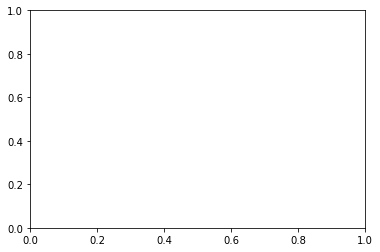

In [329]:
def surviver_C_dot_deltaR_star(analyzer):
    reconstructedC,_,_=analyzer.reconstruct_C_m_k()
    _, deltaR=analyzer.get_diff_N_R()
    result_list=[]
    for i in range(len(reconstructedC)):
        result_list.append((reconstructedC[i]@deltaR[i]))
    print('result is',result_list)    
    return result_list

kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins='auto', ec="k",range=[-1.5,0.5])
plot_histogram_results(results_dict, surviver_C_dot_deltaR_star,  '<C|δR>','frequency',kwargs)
   



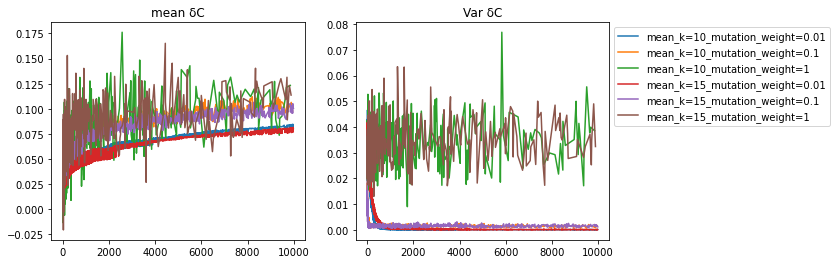

<Figure size 1440x288 with 0 Axes>

In [229]:

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
plt.figure().set_figwidth(20)

axs[ 0].set_title('mean δC')
axs[ 1].set_title('Var δC')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index']
        mean_invader_C, var_invader_C = [],[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        for i in range(len(reconstructed_C)):
            mean_invader_C.append(np.mean(reconstructed_C[i][-1]))
            var_invader_C.append(np.var(reconstructed_C[i][-1]))
        axs[0].plot(x_values, mean_invader_C, label=param_key)
        axs[1].plot(x_values,var_invader_C, label=param_key)
axs[1].legend(bbox_to_anchor=(1, 1))

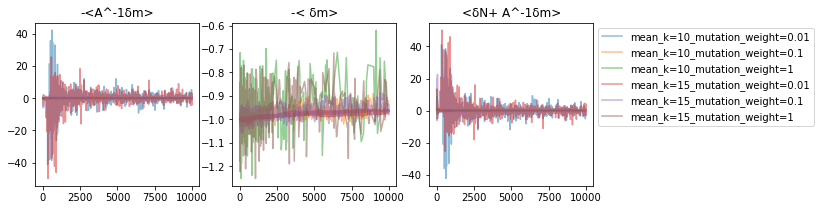

<Figure size 1440x288 with 0 Axes>

In [230]:

fig, axs = plt.subplots(1, 3,figsize=(10, 3))
plt.figure().set_figwidth(20)

axs[0].set_title('-<A^-1δm>')
axs[1].set_title('-< δm>')
axs[2].set_title('<δN+ A^-1δm>')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionm=result['List_invasionm']
            
        mean_Ainv_deltam = []
        mean_deltam=[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        
        Ndiff, Rdiff=analyzer.get_diff_N_R()
        meanNdiff=[]   
            
        for i in range(0,len(reconstructed_C)-1):
            meanNdiff.append(np.mean(Ndiff[i]))
            C=reconstructed_C[i]
            A=C@np.transpose(C)
            Ainv=np.linalg.inv(A)
            #unfinished from here
            deltam=listinvasionm[i]
            
            mean_Ainv_deltam.append(np.mean(np.transpose(Ainv)[-1]*deltam))
            mean_deltam.append(np.mean(deltam))
            
        axs[0].plot(x_values,-np.array(mean_Ainv_deltam), label=param_key,alpha=0.5)
        
        axs[1].plot(x_values,-np.array(mean_deltam), label=param_key,alpha=0.5)
        axs[2].plot(x_values,(np.array(meanNdiff)+np.array(mean_Ainv_deltam)), label=param_key,alpha=0.5)
        #axs[2].set_yscale('log')
axs[2].legend(bbox_to_anchor=(1, 1))



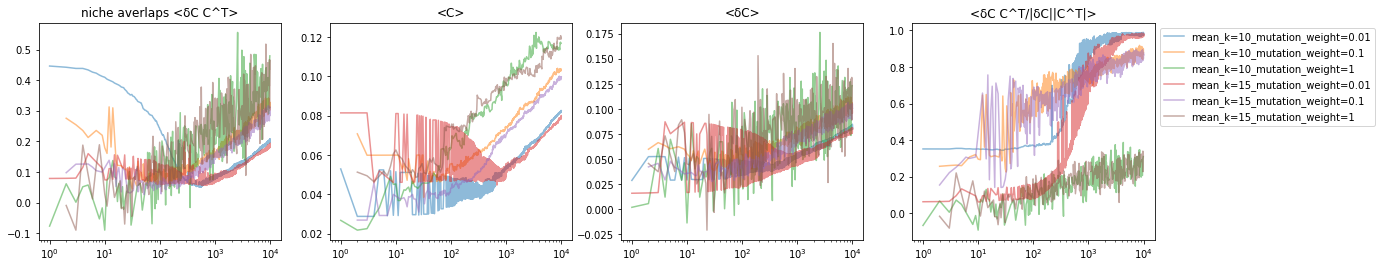

<Figure size 1440x288 with 0 Axes>

In [231]:

fig, axs = plt.subplots(1, 4,figsize=(20, 4))
plt.figure().set_figwidth(20)

axs[0].set_title('niche averlaps <δC C^T>')
axs[1].set_title('<C>')
axs[2].set_title('<δC>')
#axs[3].set_title('<δC C^T>/<C>/<δC>')
axs[3].set_title('<δC C^T/|δC||C^T|>')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionc=result['List_invasionC']
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        nicheoverlaps=[]
        Caverage=[]
        invasionCaverage=[]
        norm_niches_overlaps=[]
        for i in range(1,len(reconstructed_C)):
            C=reconstructed_C[i][:-1] #C excludes the invader itself
            Caverage.append(np.mean(np.ndarray.flatten(C)))
            nicheoverlaps.append(np.mean(C@listinvasionc[i][0]))
            invasionCaverage.append(np.mean(listinvasionc[i][0]))
            norm_niches_overlaps.append(np.mean(np.array(C@listinvasionc[i][0])/np.linalg.norm(C,axis=1)/np.linalg.norm(listinvasionc[i][0])))
        axs[0].plot(x_values,nicheoverlaps, label=param_key,alpha=0.5)
        axs[1].plot(x_values,Caverage, label=param_key,alpha=0.5)
        axs[2].plot(x_values,invasionCaverage, label=param_key,alpha=0.5)
        
        #axs[3].plot(x_values,np.array(nicheoverlaps)/np.array(Caverage)/np.array(invasionCaverage), label=param_key,alpha=0.5)
        axs[3].plot(x_values,norm_niches_overlaps, label=param_key,alpha=0.5)
        
        
        axs[0].set_xscale('log')
        axs[1].set_xscale('log')
        axs[2].set_xscale('log')
        axs[3].set_xscale('log')
        
        
        
axs[3].legend(bbox_to_anchor=(1, 1))

